## Final Project Submission

Please fill out:
* Student name: __Scott Okamura__
* Student pace: ___self paced___ / part time / full time
* Scheduled project review date/time: __2/4/2021 5:00 AM HST__
* Instructor name: __Jeff Herman__
* Blog post URL:

# Problem Statement

The Japanese yen and American dollar have a significant relationship in my home state of Hawaii. I also travel to Japan as often as I possibly can. Because of these reasons, I have always had my eye on the exchange rate between yen and USD. This project was my attempt at forecasting the future exchange rates of yen <--> USD to predict when would be the best time for me to exchange my money.

My question was simple: ___When should I exchange USD for yen?___

Source: Federal Reserve Bank of St. Louis (https://fred.stlouisfed.org/series/DEXJPUS). 

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import warnings
from math import sqrt

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA, ARIMA

from sklearn.metrics import mean_squared_error

# Importing Data

In [2]:
df = pd.read_csv('DEXJPUS1.csv')
df.head()

,DATE,DEXJPUS
0,2011-01-24,82.4400
1,2011-01-25,82.3500
2,2011-01-26,82.2700
3,2011-01-27,83.0300
4,2011-01-28,82.0300


In [3]:
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
df.columns = ['yen']
df.head()

,yen
DATE,
2011-01-24,82.4400
2011-01-25,82.3500
2011-01-26,82.2700
2011-01-27,83.0300
2011-01-28,82.0300


In [4]:
df.shape

(2610, 1)

In [5]:
df.dtypes

yen    object
dtype: object

In [6]:
df['yen'] = pd.to_numeric(df['yen'], errors='coerce')
df.dtypes

yen    float64
dtype: object

In [7]:
df.isnull().sum()

yen    109
dtype: int64

In [8]:
df.loc[df['yen'].isnull()]

,yen
DATE,
2011-02-21,NaN
2011-05-30,NaN
2011-07-04,NaN
2011-09-05,NaN
2011-10-10,NaN
...,...
2020-12-24,NaN
2020-12-25,NaN
2021-01-01,NaN


There are 109 null values found in the dataset. Assuming this is either a computer or human error, I will be replacing the NaN's with the average value between the previous and next value. This can be done using `.interpolate()` and setting `method='linear'`.

In [9]:
df.interpolate(method='linear', inplace=True)
df.isnull().sum()

yen    0
dtype: int64

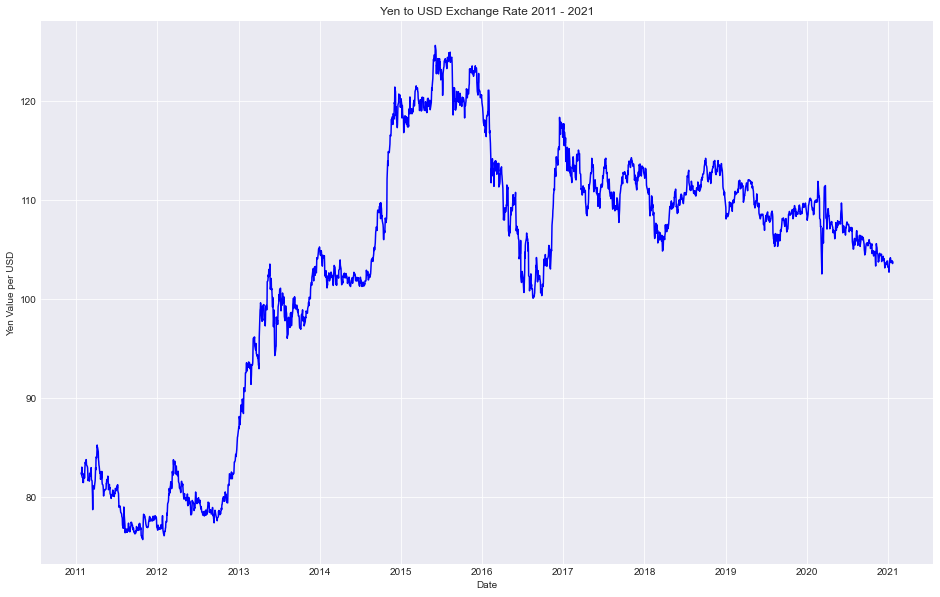

In [10]:
# df.plot(figsize=(16,10))
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(16,10))
plt.plot(df.index, df['yen'], c='b')
plt.title('Yen to USD Exchange Rate 2011 - 2021')
plt.xlabel('Date')
plt.ylabel('Yen Value per USD')
plt.show()


Now that the data is in the proper format, we can start checking for stationarity. The dataset must be stationary in order for the time series models to properly make accurate predictions. Having a __stationary__ dataset does not mean that the data doesn't change over time. Stationarity is based on values such as __mean__ and __covariance__. 

A quick plot of our dataset shows that the set is not stationary. There are _seemingly_ random peaks and troughs in the data. We can also quantify the stationarity by using __statistical testing__ such as the __Augmented Dickey-Fuller__ (ADF) test. The ADF test will check stationarity by using __differencing__. The __Kwiatkowski-Phillips-Schmidt-Shin__ (KPSS), another statistical test, checks for stationarity by removing trends in the dataset.

In [11]:
adf_test = adfuller(df)
print('stat=%.3f, p=%.3f' % adf_test[0:2])
if adf_test[1] > 0.05:
    print('Probably not Stationary')
else:
    print('Probably Stationary')

stat=-1.676, p=0.444
Probably not Stationary


In [12]:
kpss_test = kpss(df, nlags='auto')
print('stat=%.3f, p=%.3f' % kpss_test[0:2])
if kpss_test[1] > 0.05:
    print('Probably Stationary')
else:
    print('Probably not Stationary')

stat=4.628, p=0.010
Probably not Stationary


/Users/scott/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


As we saw with the line plot, both the ADF and KPSS tests also show that data is not stationary.

`statsmodels` has a `seasonal_decompose` function that will visualize the dataset along with its __trend, seasonal, and residuals__. 

<Figure size 1152x720 with 0 Axes>

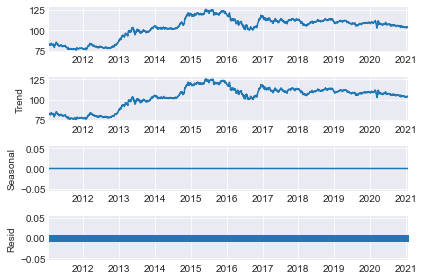

In [13]:
decomp = seasonal_decompose(df, model='additive', period=1)

plt.figure(figsize=(16,10))
decomp.plot();

The graphs above show that the pattern that our dataset follows is _very_ similar to the pattern of the trend line. This implies that if we are able to remove the trends from our data, we can possibly make it stationary.

To remove the trends, there are a few different common approaches. The dataset can be __transformed__ using `np.log` to make the time series more _uniform_. This can also be substituted with finding __power__, as well as __square/cube root__, transforming.

After log transforming, I will also subtract out the rolling mean using `.rolling()`. Subtracting the rolling mean from a time series is another method to make the data more stationary. 

In [14]:
df_log = np.log(df)
roll_mean = df_log.rolling(window=20, center=False).mean()
df_log_mean = df_log - roll_mean
df_log_mean.dropna(inplace=True)

In [15]:
adf_test = adfuller(df_log_mean)
print('stat=%.3f, p=%.3f' % adf_test[0:2])
if adf_test[1] > 0.05:
    print('Probably not Stationary')
else:
    print('Probably Stationary')

stat=-8.332, p=0.000
Probably Stationary


In [16]:
kpss_test = kpss(df_log_mean, nlags='auto')
print('stat=%.3f, p=%.3f' % kpss_test[0:2])
if kpss_test[1] > 0.05:
    print('Probably Stationary')
else:
    print('Probably not Stationary')

stat=0.344, p=0.100
Probably Stationary


/Users/scott/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Great! Our dataset is now stationary, according to our 2 stationarity tests. The plot for the modified dataset will clearly illustrate the change in __mean__ and __variance__ from the original set. 

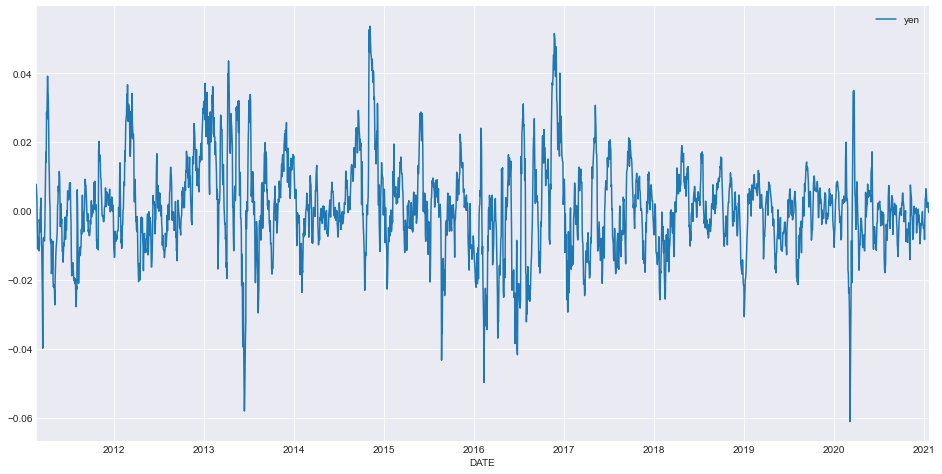

In [17]:
df_log_mean.plot(figsize=(16,8));

Now that the data is stationary, we can move on to the next step of building a time series model.

# Determining Order of ARMA Models

__ARMA__ models (Auto-Regressive Moving Average) are one of the most common methods of forecasting time series data. In order to use an ARMA model, the data must be stationary. Once that in completed, the order of the model, __p__ and __q__, need to be determined. These parameters can be determined by visualization (PACF and ACF plots) or by doing an interative search over a number of possible parameters. 

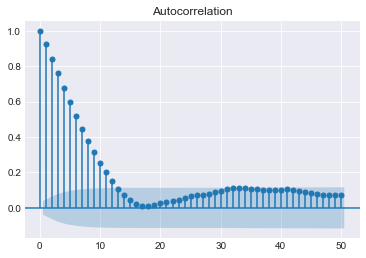

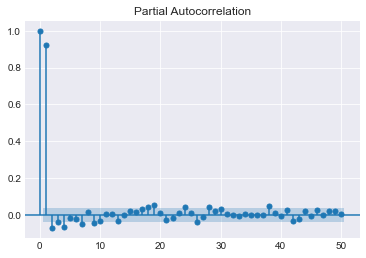

In [18]:
plot_acf(df_log_mean, lags=50)
plot_pacf(df_log_mean, lags=50)
plt.show()

The __pacf__ plot shows a single large spike at `lag = 1`, indicating the ideal __q__ term for our ARMA model. The __acf__ plot is a bit more difficult, as it shows large spikes from `lag = 1` to `lag = 12`. In order to determine the best __p__ term, we will investigate the results of the first 3 lags first to see which values are significant in our model. 

In [19]:
model_arma = ARMA(df_log_mean, (1,1))
model_arma_fit = model_arma.fit()
print(model_arma_fit.summary())

/Users/scott/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                    yen   No. Observations:                 2591
Model:                     ARMA(1, 1)   Log Likelihood                9965.541
Method:                       css-mle   S.D. of innovations              0.005
Date:                Tue, 16 Feb 2021   AIC                         -19923.083
Time:                        18:47:16   BIC                         -19899.644
Sample:                    02-18-2011   HQIC                        -19914.589
                         - 01-22-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.695      0.487      -0.002       0.003
ar.L1.yen      0.9120      0.009    105.419      0.000       0.895       0.929
ma.L1.yen      0.0746      0.021      3.634      0.0

In [20]:
model_arma2 = ARMA(df_log_mean.squeeze(), (2,1))
model_arma2_fit = model_arma2.fit()
print(model_arma2_fit.summary())

/Users/scott/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                    yen   No. Observations:                 2591
Model:                     ARMA(2, 1)   Log Likelihood                9976.201
Method:                       css-mle   S.D. of innovations              0.005
Date:                Tue, 16 Feb 2021   AIC                         -19942.402
Time:                        18:47:17   BIC                         -19913.103
Sample:                    02-18-2011   HQIC                        -19931.785
                         - 01-22-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.895      0.371      -0.001       0.003
ar.L1.yen      1.7573      0.048     36.687      0.000       1.663       1.851
ar.L2.yen     -0.7808      0.043    -17.993      0.0

In [21]:
model_arma3 = ARMA(df_log_mean, (3,1))
model_arma3_fit = model_arma3.fit()
print(model_arma3_fit.summary())

/Users/scott/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                    yen   No. Observations:                 2591
Model:                     ARMA(3, 1)   Log Likelihood                9976.204
Method:                       css-mle   S.D. of innovations              0.005
Date:                Tue, 16 Feb 2021   AIC                         -19940.409
Time:                        18:47:18   BIC                         -19905.250
Sample:                    02-18-2011   HQIC                        -19927.668
                         - 01-22-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.895      0.371      -0.001       0.003
ar.L1.yen      1.7608      0.064     27.362      0.000       1.635       1.887
ar.L2.yen     -0.7860      0.076    -10.309      0.0

The `summary()` attribute for the `ARMA()` function gives us a full table of our model results. Although there is a lot of very useful information in the table, we are mostly interested in 2 values: __AIC__ and `P>|z|`.

The p value will tell us the significance of each feature weight in our model. All of our parameters have a very low p value, below `0.000`, except for one in our `ARMA(3,1)` model. This indicates that the 3rd lag is not significant and can be ignored. This also indicates that lags `> 3` will also not be significant. 

The AIC (Akaike Information Criterion) value is a measurement of how well a model is fitting the data without over-fitting. The fewer parameters that a model uses to achieve a high goodness-of-fit score, the lower the AIC value will be. Between `ARMA(1,1)` and `ARMA(2,1)`, the latter had the lower AIC, albeit by a very tiny margin. 

[0.00137063 0.0013151  0.00126089 0.00120898 0.0011601  0.00111473
 0.00107317 0.00103557 0.00100194 0.00097221 0.00094622 0.00092376
 0.0009046  0.00088845 0.00087504 0.00086409 0.00085531 0.00084843
 0.0008432  0.00083939]


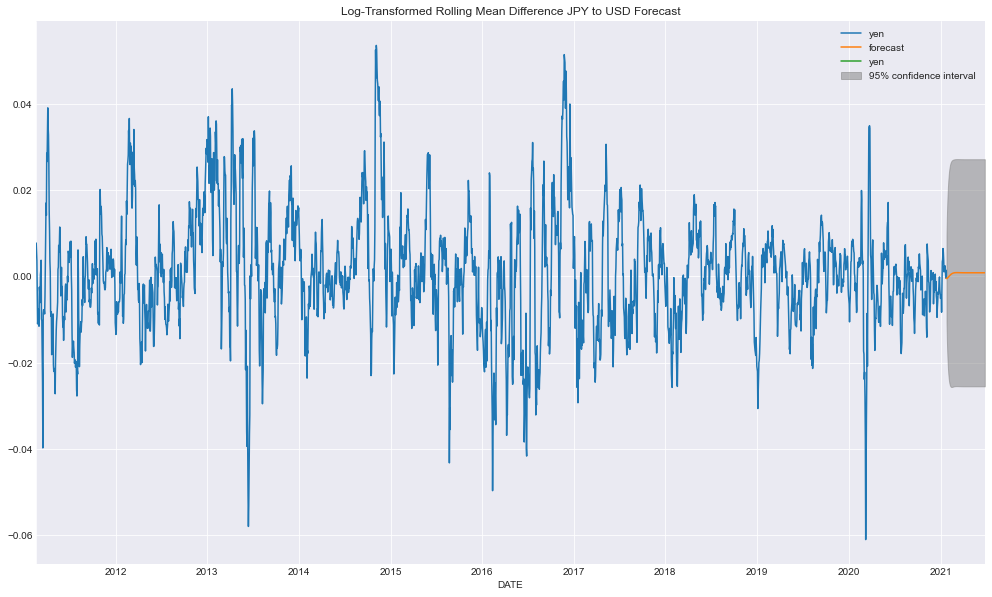

In [22]:
pred = model_arma2_fit.forecast(20, alpha=0.05)[0]
print(pred)

fig, ax = plt.subplots(figsize=(17,10))
ax = df_log_mean.loc['2011':].plot(ax=ax)
fig = model_arma2_fit.plot_predict(2590, 2700,
                                   dynamic=True, ax=ax)
plt.title('Log-Transformed Rolling Mean Difference JPY to USD Forecast')
plt.show()

In [23]:
pd.DataFrame(pred, index=(pd.date_range(start='2021-01-23', periods=20, freq='d')),
             columns=['Log-Transformed Yen Value'])

,Log-Transformed Yen Value
2021-01-23,0.001371
2021-01-24,0.001315
2021-01-25,0.001261
2021-01-26,0.001209
2021-01-27,0.001160
2021-01-28,0.001115
2021-01-29,0.001073
2021-01-30,0.001036
2021-01-31,0.001002
2021-02-01,0.000972


In [24]:
np.exp(pred)

array([1.00137157, 1.00131597, 1.00126168, 1.00120971, 1.00116077,
       1.00111535, 1.00107375, 1.00103611, 1.00100244, 1.00097268,
       1.00094667, 1.00092419, 1.00090501, 1.00088885, 1.00087542,
       1.00086446, 1.00085567, 1.00084879, 1.00084356, 1.00083974])

The prediction plot above does not help to predict the exchange rate very much. Since the entire dataset was log transformed then had the rolling mean subtracted out, the predicted values would also need to be converted back into its original units after taking in to account the subtracted mean.

To simplify this process, we can use the __ARIMA__ model in statsmodels. The difference between the ARIMA and ARMA model is the addition of the __Integrated__ paramater, ___d___. The value of $d$ will determine the number of lag values to subtract from the current date value. This is similar to the `.diff()` method, the only difference being that the model will find the best fit value for us, given the right parameters.

# Finding ARIMA Parameters

Let us first find the ideal lag values for our log transformed dataset manually. We start with this since we know that the original dataset is not stationary and followed a very similar pattern to the trend (but not _seasonality_!). Once we determine the ideal $d$ parameter, we can have `ARIMA` determine the best and see if it matches with our findings.

In [25]:
def stationarity_tests(series):
    '''
    Input: time series data
    
    Output: ADF and KPSS test results for time series
    '''
    
    warnings.filterwarnings("ignore")
    
    # ADF test
    result = adfuller(series)
    print(f'ADF Statistic: {round(result[0], 3)}')
    print(f'n_lags: {round(result[1],3)}')
    print(f'p-value: {round(result[1],3)}')
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}, {round(value,3)}')  
    if result[1] > 0.05:
        print('Probably not stationary\n')
    else:
        print('Probably stationary\n')
        
    # KPSS test
    statistic, p_value, n_lags, critical_values = kpss(series)
    # Format Output
    print(f'KPSS Statistic: {round(statistic,3)}')
    print(f'p-value: {p_value}')
    print(f'n_lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    if p_value < 0.05:
        print('Probably not stationary\n')
    else:
        print('Probably stationary\n')


In [26]:
# stationarity check for the log transformed series
stationarity_tests(df_log)

ADF Statistic: -1.644
n_lags: 0.46
p-value: 0.46
Critical Values:
   1%, -3.433
Critical Values:
   5%, -2.863
Critical Values:
   10%, -2.567
Probably not stationary

KPSS Statistic: 5.118
p-value: 0.01
n_lags: 28
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Probably not stationary



In [27]:
df_log_diff1 = df_log.diff(1).dropna()
stationarity_tests(df_log_diff1)

ADF Statistic: -49.569
n_lags: 0.0
p-value: 0.0
Critical Values:
   1%, -3.433
Critical Values:
   5%, -2.863
Critical Values:
   10%, -2.567
Probably stationary

KPSS Statistic: 0.284
p-value: 0.1
n_lags: 28
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Probably stationary



A lag value of `d=1` looks to be enough to make our dataset stationary. We can now see if the `ARIMA` model will produce the same results. To check this, we will essentially be doing a pseudo-grid search by passing in a range of values for __p, d, q__. Just like with a grid search, we need to be mindful of the range of parameter values we set. The more values we test iteratively, the more computationally expensive this process becomes.

With our __ARMA__ model, we found the best parameters to be ARMA(2,1). We should expect to see similar parameters for our __ARIMA__ model. In addition to the standard ARMA parameters, the ARIMA model will also take into consideration the effects of seasonality. The seasonality parameters, __P, D, Q__, have the same meanings as their non-seasonal counterparts. The final value in the ARIMA model __s__ is the periodicity of the time series. We will set `s = 12` for now although we shouldn't expect to see any seasonal component from our ARIMA model since our original dataset _did not_ show seasonal trends.

In [28]:
p = range(0, 3)
d = range(0, 2)
q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

warnings.filterwarnings("ignore")

diffyearly = set()
for n, param in enumerate(pdq):
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_log,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            diffyearly.add((param, param_seasonal, results.aic))
        except:
            continue
    print(f'{len(pdq) - (n+1)} iterations remaining...')
            
sorted_diffyearly = sorted(diffyearly, key=lambda x: x[2])

mod = sm.tsa.statespace.SARIMAX(df_log,
                                order=sorted_diffyearly[0][0],
                                seasonal_order=sorted_diffyearly[0][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

11 iterations remaining...
10 iterations remaining...
9 iterations remaining...
8 iterations remaining...
7 iterations remaining...
6 iterations remaining...
5 iterations remaining...
4 iterations remaining...
3 iterations remaining...
2 iterations remaining...
1 iterations remaining...
0 iterations remaining...
                               SARIMAX Results                                
Dep. Variable:                    yen   No. Observations:                 2610
Model:               SARIMAX(1, 0, 0)   Log Likelihood                9914.197
Date:                Tue, 16 Feb 2021   AIC                         -19824.395
Time:                        18:57:06   BIC                         -19812.661
Sample:                    01-24-2011   HQIC                        -19820.144
                         - 01-22-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|

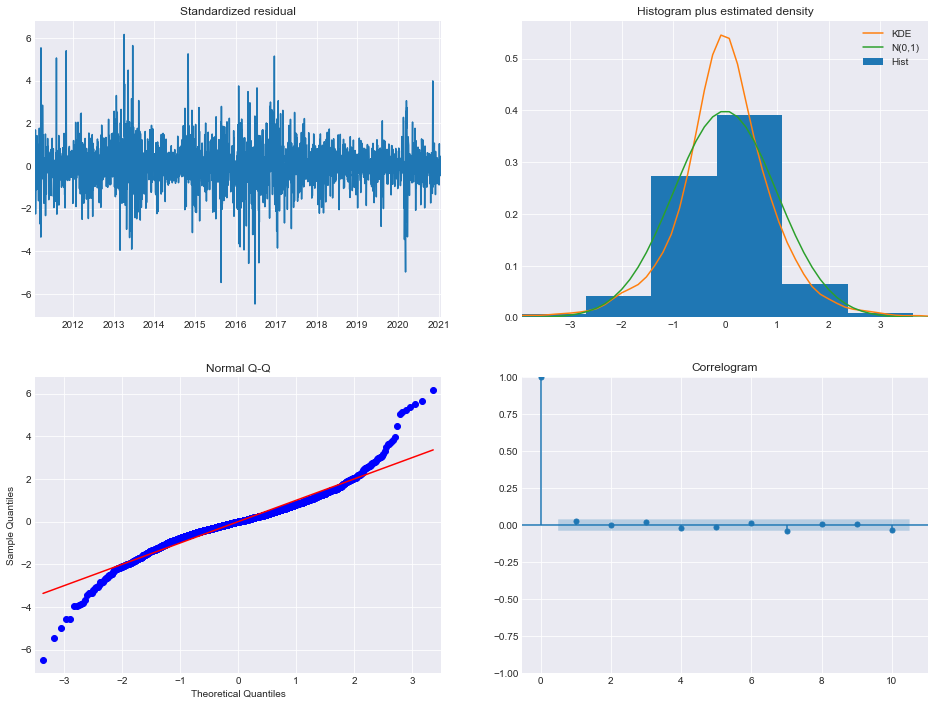

In [29]:
results.plot_diagnostics(figsize=(16,12));

In [30]:
sorted_diffyearly[:3]

[((1, 0, 0), (0, 0, 0, 12), -19824.394678229306),
 ((1, 1, 0), (0, 0, 0, 12), -19817.517128912354),
 ((0, 1, 0), (0, 0, 0, 12), -19817.221244409284)]

The ARIMA model determined that the best fit for our log transformed series was a SARIMAX(1,0,0)x(0,0,0,12), meaning there was no seasonal component to the model, as we predicted and found while exploring our series.
Surprisingly, the ARMA(2,1) model produced a lower __AIC__ value than our ARIMA(1,0,0) model. However, before comparing the models by their AIC scores and determining the best choice, we can further investigate the results of our SARIMAX model in the `plot_diagnostics()` method.

The 4 plots above provide validation visuals for our model. The _standardized residual_ plot shows that the residuals over time in our series does not show any sort of seasonality and instead seems to be some noise/trends. The lack of seasonality is further supported by the _correlogram_ plot. This plot shows that the residuals of our values do not correlate with the time lagged version of the same residual.

The last 2 plots are not as nice to look at. The _normal Q-Q_ plot shows some normality in our residuals but falls further away from the linear trend line at either end. This Q-Q plot pattern is typical of datasets that have more extreme values than a normal distribution. This skew from a normal distribution is also reflected in the final _histogram plus estimated density_ plot. We can see that our data does not have an evenly distributed histogram and our __KDE__ does not mirror the normally distributed curve `N(0,1)`.



In [31]:
pred = results.get_prediction(start=pd.to_datetime('2020'))
pred_conf = pred.conf_int()

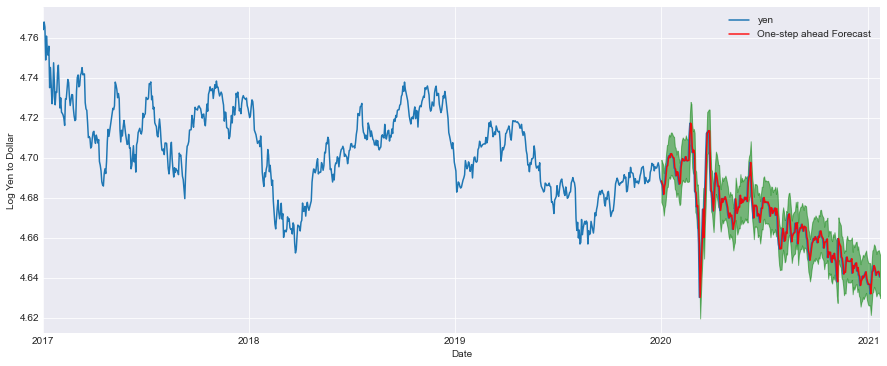

In [35]:
plt.rcParams['figure.figsize'] = 15, 6

ax = df_log['2017':].plot(label='log observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast',
                         color='r', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Log Yen to Dollar')
plt.legend()
plt.show()

In [36]:
# real and predicted values
yen_pred = pred.predicted_mean
yen_true = df_log.loc['2020':, 'yen']

# Compute the mean square error
mse = ((yen_pred - yen_true) ** 2).mean()
print(f'Log-Transformed Mean Squared Error: {mse}')
print(f'Log-Transformed RMSE: {np.sqrt(mse)}')

Log-Transformed Mean Squared Error: 2.3979638027034765e-05
Log-Transformed RMSE: 0.004896900859424741


In [37]:
# reversing the log transformation
exp_mse = ((np.exp(yen_pred) - np.exp(yen_true)) **2).mean()
print(f'Mean Squared Error: {exp_mse}')
print(f'RMSE: {np.sqrt(exp_mse)}')

Mean Squared Error: 0.27342094541709405
RMSE: 0.5228966871353212


Using a one-step ahead forecast to predict the change in exchange rate, the model was able to produce an __RMSE__ of `0.523`. This result does seem to indicate that the model is fairly accurate with an RMSE close to 0. We can see if this is reflected in a different validation measure, __walk-forward validation__. This method of validation is similar to cross-validation as it is used to make multiple sets of train and validation sets in order to find the average error. However since we are working with a time series, the data must be kept in its original order, rather than being shuffled around randomly like in _K-fold_ validation.

In [38]:
# evaluate an ARIMA model using a walk-forward validation

# split into train and test sets
X = df_log['yen']
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f'predicted={yhat}, expected={obs}')


predicted=[4.6952941], expected=4.697931666069403
predicted=[4.69784838], expected=4.696837374513915
predicted=[4.69675455], expected=4.693181063310805
predicted=[4.69309967], expected=4.6946451924156944
predicted=[4.69456327], expected=4.696563614417302
predicted=[4.69648099], expected=4.689878913915045
predicted=[4.68979889], expected=4.696381066041475
predicted=[4.6962985], expected=4.700116663297045
predicted=[4.70003272], expected=4.700389452569025
predicted=[4.70030545], expected=4.698205051955281
predicted=[4.6981219], expected=4.697749367281185
predicted=[4.69766643], expected=4.6982961639775755
predicted=[4.69821307], expected=4.704110133842995
predicted=[4.70402492], expected=4.705015520957808
predicted=[4.70493003], expected=4.708268143991659
predicted=[4.70818154], expected=4.7066431549187255
predicted=[4.70655715], expected=4.705377446405117
predicted=[4.70529194], expected=4.706010500914163
predicted=[4.70592481], expected=4.7066431549187255
predicted=[4.70655728], expect

predicted=[4.67088998], expected=4.674136390452814
predicted=[4.67406702], expected=4.676001366748682
predicted=[4.67593119], expected=4.679628096906101
predicted=[4.67955634], expected=4.681853410759049
predicted=[4.68178073], expected=4.683241721408247
predicted=[4.68316847], expected=4.681575517190497
predicted=[4.68150301], expected=4.683241721408247
predicted=[4.68316853], expected=4.683704063642198
predicted=[4.68363071], expected=4.68213122712422
predicted=[4.68205857], expected=4.681668156960816
predicted=[4.68159573], expected=4.677211738853062
predicted=[4.67714126], expected=4.675815025557423
predicted=[4.67574518], expected=4.680092112505351
predicted=[4.68002042], expected=4.679070993827626
predicted=[4.67899977], expected=4.682594082952895
predicted=[4.68252135], expected=4.68314922730468
predicted=[4.6830763], expected=4.679349584162343
predicted=[4.6792783], expected=4.674789527868148
predicted=[4.67472027], expected=4.670583324536324
predicted=[4.67051598], expected=4.

predicted=[4.67686344], expected=4.674882798399391
predicted=[4.67481468], expected=4.671238785957796
predicted=[4.67117243], expected=4.669739956637391
predicted=[4.66967434], expected=4.672267929520586
predicted=[4.67220112], expected=4.670583324536324
predicted=[4.67051735], expected=4.671145174911624
predicted=[4.67107895], expected=4.668332760945732
predicted=[4.66826792], expected=4.664099253517379
predicted=[4.66403651], expected=4.666829566374819
predicted=[4.66676548], expected=4.66814498514948
predicted=[4.66808028], expected=4.679349584162343
predicted=[4.67927948], expected=4.675908200493433
predicted=[4.67583972], expected=4.672080891270718
predicted=[4.67201425], expected=4.673669602412784
predicted=[4.67360224], expected=4.675349020609338
predicted=[4.67528087], expected=4.675162557808126
predicted=[4.67509452], expected=4.681112189563248
predicted=[4.68104138], expected=4.677118685300675
predicted=[4.67704974], expected=4.679256729340789
predicted=[4.67918681], expected

predicted=[4.64443641], expected=4.645736147734753
predicted=[4.64568486], expected=4.647079589065301
predicted=[4.64702759], expected=4.647271362006727
predicted=[4.64721928], expected=4.643236386794547
predicted=[4.64318648], expected=4.644967655862158
predicted=[4.64491683], expected=4.6414056785701865
predicted=[4.64135679], expected=4.640440800070011
predicted=[4.64039245], expected=4.635990328327978
predicted=[4.63594444], expected=4.638121286127777
predicted=[4.63807423], expected=4.638991734463602
predicted=[4.63894422], expected=4.640730361386642
predicted=[4.64068191], expected=4.639764830752591
predicted=[4.63971691], expected=4.64079469696102
predicted=[4.64074623], expected=4.641823503636127
predicted=[4.64177449], expected=4.64285125295578
predicted=[4.6428017], expected=4.639571612705423
predicted=[4.63952385], expected=4.637734176861354
predicted=[4.63768743], expected=4.636571949127623
predicted=[4.63652586], expected=4.636571949127623
predicted=[4.63652587], expected=

In [39]:
# finding MSE/RMSE of walk-forward validation
rmse = sqrt(mean_squared_error(np.exp(test), np.exp(predictions)))
print(f'Test RMSE: {round(rmse, 4)}')
print(f'Test MSE: {rmse**2}')

Test RMSE: 0.4535
Test MSE: 0.2056433307661961


In [60]:
predictions

[array([4.6952941]),
 array([4.69784838]),
 array([4.69675455]),
 array([4.69309967]),
 array([4.69456327]),
 array([4.69648099]),
 array([4.68979889]),
 array([4.6962985]),
 array([4.70003272]),
 array([4.70030545]),
 array([4.6981219]),
 array([4.69766643]),
 array([4.69821307]),
 array([4.70402492]),
 array([4.70493003]),
 array([4.70818154]),
 array([4.70655715]),
 array([4.70529194]),
 array([4.70592481]),
 array([4.70655728]),
 array([4.70673796]),
 array([4.70691861]),
 array([4.70673805]),
 array([4.71007373]),
 array([4.70727978]),
 array([4.70872285]),
 array([4.71286006]),
 array([4.71742708]),
 array([4.71554911]),
 array([4.71823096]),
 array([4.71537015]),
 array([4.71483288]),
 array([4.71043399]),
 array([4.71133335]),
 array([4.71286036]),
 array([4.7115132]),
 array([4.71581792]),
 array([4.71456435]),
 array([4.71312973]),
 array([4.71286056]),
 array([4.71312984]),
 array([4.70818257]),
 array([4.6982141]),
 array([4.70121507]),
 array([4.70493107]),
 array([4.70384

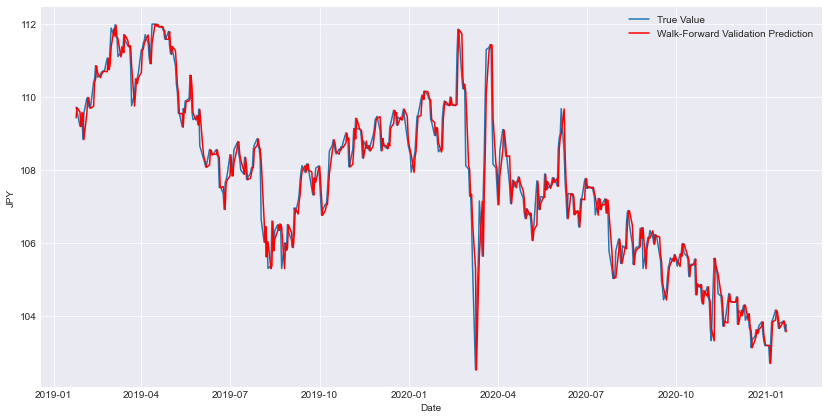

In [61]:
predict = pd.DataFrame(predictions, index=test.index)
plt.figure(figsize=(14,7))
plt.plot(np.exp(test), label='True Value')
plt.plot(np.exp(predict), color='red', label='Walk-Forward Validation Prediction')
plt.xlabel('Date')
plt.ylabel('JPY')
plt.legend()
plt.show()

The walk-forward validation of our data resulted in `RMSE = 0.453`. This result shows that our model was able to predict the change in exchange rate of the Japanese yen fairly accurately. We can see from the plot above that our prediction closely followed the true values. The walk-forward validation improved the RMSE from the one-step ahead forecast, but only by a very small margin of `0.07`.

`statsmodels` also has a built-in out-of-sample `get_forecast` function to test the model on future predictions. By plotting the future predictions and the time series data, we can get a visual representation of our model's predictions and how it reflects the previous changes in exchange rate.

In [62]:
forecast = results.get_forecast(steps=500)

fc_conf = forecast.conf_int()

___Spoiler alert:___ This didn't work well for this model.

The out-of-sample forecasting for this model generated a not-so-useful prediction for the yen to dollar exchange rate. The plot below shows the confidence interval of the predicted future prices to be cone-shaped. According to the forecast, the yen to dollar exchange rate in 2022 could be anywhere between 89 and 125. With __2020__ being the year that it was, maybe the yen/dollar rate will truly fluctuate that drastically in the next year.

In [63]:
np.exp(fc_conf['2022':]).head(1)

,lower yen,upper yen
2022-01-03,89.643077,125.132536


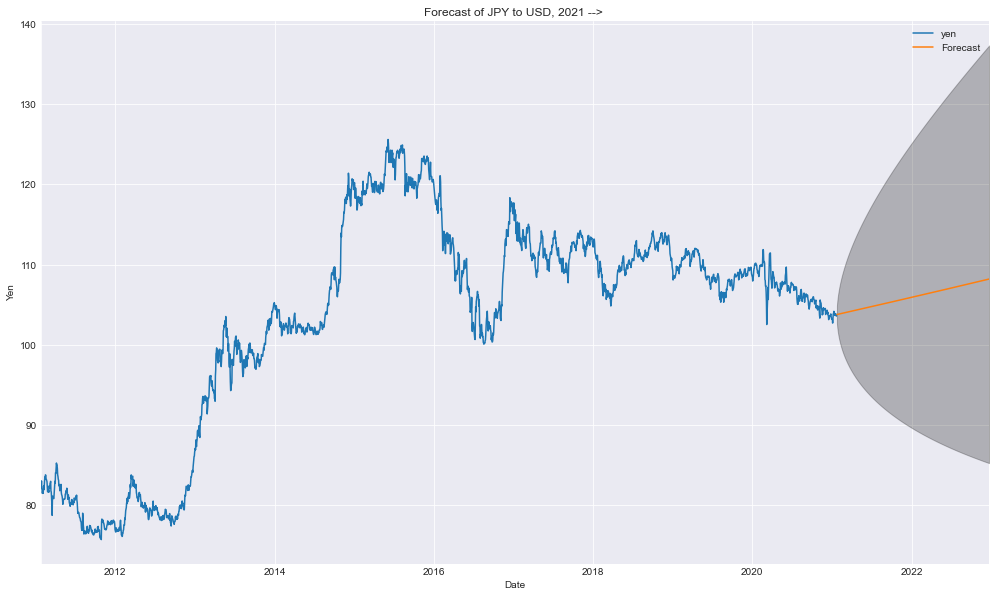

In [64]:
# Plot future predictions with confidence intervals
fc_confxp = np.exp(fc_conf)
ax = (np.exp(df_log)).plot(label='observed', figsize=(17, 10))
np.exp(forecast.predicted_mean).plot(ax=ax, label='Forecast')
ax.fill_between(fc_confxp.index,
                fc_confxp.iloc[:, 0],
                fc_confxp.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Yen')
ax.set_title('Forecast of JPY to USD, 2021 --> ')

plt.legend()
plt.show()

In [65]:
def generate_range():
    print('Date of interest:')
    dt = input()
    date = pd.to_datetime(dt)
    ranges = np.exp(fc_conf[date:]).head(1)
    lower = round(ranges['lower yen'].values[0],2)
    upper = round(ranges['upper yen'].values[0],2)
    return (f'Yen to Dollar Exchange Rate Range on {date.month_name()} {date.day}, {date.year}: ' 
          + str(lower) + ' --> ' + str(upper))

In [66]:
generate_range()

Date of interest:
february 16, 2021


'Yen to Dollar Exchange Rate Range on February 16, 2021: 99.46 --> 108.55'

# Results

___When should I exchange USD for yen?___

Magic 8-ball answer: _Cannot predict now, try again later._

We were able to fit a model that could produce an `RMSE = 0.453`. This would have been a great result had it not been for the poor forecasting. This model can give a range of prices for future predictions, but the range is far too large to be useful to anyone interested in the foreign exchange market.

# Future Work
There are many areas of improvement for this project. However, the ones that I would want to immediately improve on, given more time and resources, would be:
1. Add additional features
    - This time series model was only using 1 feature to predict the change in exchange rate. Obviously, foreign exchange rates are not dependent on their previous rates alone. There could be any number of factors such as the exchange of other currencies, major international events (e.g. _pandemic_), or other unforeseen events (e.g. __GME__, coups, etc) with international ramifications.
2. Normality
    - As discussed earlier, the Q-Q plot for our __ARIMA(1,0,0)__ model showed a poor relationship with the linear trend line toward either end of the plot as well as skewing from the __N(0,1)__ histogram and KDE plot. I believe that there is a lot to discover with further cleaning of the data. This could also help with feature engineering after adding additional features.
3. Forecasting
    - I would want to improve on the forecasting after feature engineering and additional data cleaning to see if it helps with the model forecast above. If not, further research and testing will have to be done to make the forecast much more accurate than what it is now.